---

## 1. OVERVIEW & METHODOLOGY

# Experiment 0.2: Dataset Selection (No-Edge vs. 20m-Edge)

**Experiment Phase:** Phase 0 - Setup Fixation  
**Date:** 2026-01-20  
**Author:** Silas Pignotti  
**Expected Runtime:** ~30-40 minutes (2 variants × 3 folds × ~5-7 min/fold)

---

### 1.1 Purpose

This notebook evaluates **which dataset (No-Edge vs. 20m-Edge filtered) provides better single-city performance** while considering the trade-off between spectral purity and genus diversity.

**Research Question:**  
Does the 20m-Edge filter (higher spectral purity, fewer genera) outperform No-Edge (more genera, potential mixed pixels) by >5% Macro-F1 on Berlin validation data?

**Null Hypothesis (H0):**  
No-Edge dataset performs within 2% of 20m-Edge dataset, making genus diversity more valuable than edge filtering.

**Alternative Hypothesis (H1):**  
20m-Edge dataset outperforms No-Edge by >5% Macro-F1, indicating spectral purity is critical despite reduced genus count.

---

### 1.2 Workflow

```
[PHASE 1: DATA PREPARATION]
├── Load pre-split train/val datasets (both variants)
├── Sample 50k trees per dataset (stratified by genus)
├── Validate data integrity (CRS, features, genera)
└── Extract feature groups (spectral only, NO CHM!)

    ↓

[PHASE 2: VARIANT TRAINING]
├── Variant A: No-Edge (13 genera, ~635k Berlin total)
└── Variant B: 20m-Edge (6 genera, ~222k Berlin total)

    ↓

[PHASE 3: EVALUATION]
├── 3-Fold Spatial Block CV per variant (pre-split blocks)
├── Track: Val Macro-F1, Train-Val Gap, Genus-wise F1
└── Apply decision criteria from Experiment Design

    ↓

[OUTPUT: Decision + Artifacts]
├── decision_dataset.md (selected dataset + reasoning)
├── dataset_comparison.csv (both variants with metrics)
├── genus_comparison.csv (F1 per genus, 6 common genera)
├── exp_0.2_results.json (full results)
├── CONFIG_PARTIAL_0.2.yaml (for Phase 1)
└── 2 PNG plots (performance + genus-level comparison)
```

### 1.3 Expected Outputs

| File | Type | Description |
|------|------|-------------|
| decision_dataset.md | Markdown | Selected dataset + reasoning |
| dataset_comparison.csv | CSV | Both variants with metrics |
| genus_comparison.csv | CSV | F1 per genus (6 common genera) |
| exp_0.2_results.json | JSON | Full experiment results |
| CONFIG_PARTIAL_0.2.yaml | YAML | Dataset choice for Phase 1 |
| exp_0.2_performance_comparison.png | PNG | Val F1 + Train-Val Gap + Genus Count |
| exp_0.2_genus_comparison.png | PNG | F1 per genus (grouped bar chart) |

---

### 1.4 Decision Criteria (from Experiment Design)

| Criterion | Condition | Action |
|-----------|-----------|--------|
| **1. Extreme Overfitting Difference** | No-Edge Gap >70% AND 20m-Edge Gap <55% | Select 20m-Edge (spectral purity critical) |
| **2. Performance Similar** | \|Δ Val-F1\| ≤ 2% | Select No-Edge (13 Genera > 6 Genera) |
| **3. 20m-Edge Significantly Better** | Δ Val-F1 < -5% | Select 20m-Edge (quality over quantity) |
| **4. Gray Zone** | -5% < Δ < -2% | Prefer No-Edge, flag for Phase 4 re-check |

**Where:**  
- Δ Val-F1 = No-Edge Val Macro-F1 - 20m-Edge Val Macro-F1
- Gap = Train Macro-F1 - Val Macro-F1 (overfitting indicator)

**Note on Overfitting:**  
Current models are expected to overfit significantly (Gap ~40-60%) due to:
- No hyperparameter tuning yet
- Default RF parameters (max_depth=None)
- Class imbalance (only class_weight='balanced', no sampling)

This is acceptable for Phase 0 - we only compare datasets, not optimize models.

---

## 2. SETUP & IMPORTS

### 2.1 Packages & Environment

In [59]:
# Standard imports
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import json
import yaml
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("Imports successful")

Imports successful


In [60]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.2 Visualization & Utility Functions

In [61]:
# Publication style configuration
PUBLICATION_STYLE = {
    'style': 'seaborn-v0_8-whitegrid',
    'figsize': (12, 7),
    'dpi_export': 300,
}

def setup_publication_style():
    """Configure matplotlib for publication-quality figures"""
    plt.rcdefaults()
    plt.style.use(PUBLICATION_STYLE['style'])
    sns.set_palette('Set2')
    plt.rcParams['figure.figsize'] = PUBLICATION_STYLE['figsize']
    plt.rcParams['savefig.dpi'] = PUBLICATION_STYLE['dpi_export']
    print("Publication style configured")

setup_publication_style()

Publication style configured


In [62]:
# Utility functions

def print_section(title, width=80):
    """Print formatted section header"""
    print("\n" + "="*width)
    print(title.center(width))
    print("="*width)

def print_subsection(title, width=80):
    """Print formatted subsection header"""
    print("\n" + "-"*width)
    print(title)
    print("-"*width)

def convert_types(obj):
    """Convert numpy types to native Python for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.Series):
        return obj.to_dict()
    elif isinstance(obj, pd.DataFrame):
        return obj.to_dict('records')
    return obj

print("Utility functions defined")

Utility functions defined


---

## 3. CONFIGURATION

### 3.1 Experiment Configuration

In [63]:
# Base directories
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")
DATA_DIR = BASE_DIR / "data/02_pipeline/05_spatial_splits/data"

# Experiment Output Directories
# Folder structure: 00_phase_0/02_experiment_dataset_selection
EXPERIMENT_ID = "02_experiment_dataset_selection"
EXPERIMENT_DIR = BASE_DIR / "data/03_experiments/00_phase_0" / EXPERIMENT_ID

RESULTS_DATA = EXPERIMENT_DIR / "data"
RESULTS_METADATA = EXPERIMENT_DIR / "metadata"
RESULTS_PLOTS = EXPERIMENT_DIR / "plots"

for d in [EXPERIMENT_DIR, RESULTS_DATA, RESULTS_METADATA, RESULTS_PLOTS]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Experiment: {EXPERIMENT_ID}")
print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Experiment directory: {EXPERIMENT_DIR}")

Experiment: 02_experiment_dataset_selection
Base directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit
Data directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/05_spatial_splits/data
Experiment directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/00_phase_0/02_experiment_dataset_selection


### 3.2 Dataset Configuration

In [64]:
# Common genera for fair comparison (Intersection of datasets)
COMMON_GENERA = ['ACER', 'BETULA', 'FRAXINUS', 'QUERCUS', 'SORBUS', 'TILIA']

# Dataset variants
VARIANTS = {
    'A': {
        'name': 'No-Edge (13 Genera)',
        'description': '13 genera, no edge filter (Baseline for Diversity)',
        'train_file': 'berlin_no_edge_train.gpkg',
        'val_file': 'berlin_no_edge_val.gpkg',
        'filter_genera': None,
        'expected_genera': 13,
    },
    'A_controlled': {
        'name': 'No-Edge (6 Genera)',
        'description': '6 genera, no edge filter (Fair Control)',
        'train_file': 'berlin_no_edge_train.gpkg',
        'val_file': 'berlin_no_edge_val.gpkg',
        'filter_genera': COMMON_GENERA,
        'expected_genera': 6,
    },
    'B': {
        'name': '20m-Edge (6 Genera)',
        'description': '6 genera, 20m edge filter (Target for Quality)',
        'train_file': 'berlin_20m_edge_train.gpkg',
        'val_file': 'berlin_20m_edge_val.gpkg',
        'filter_genera': None, # Implicitly filtered by dataset creation
        'expected_genera': 6,
    }
}

# Sampling configuration
DATASET_CONFIG = {
    'city': 'Berlin',
    'sample_size_per_dataset': 50000,  # Per variant
    'stratify_by': 'genus_latin',
    'random_state': 42,
}

print("Dataset configuration loaded")
print(f"Sample size per variant: {DATASET_CONFIG['sample_size_per_dataset']:,}")
print(f"Variants: {', '.join([v['name'] for v in VARIANTS.values()])}")

Dataset configuration loaded
Sample size per variant: 50,000
Variants: No-Edge (13 Genera), No-Edge (6 Genera), 20m-Edge (6 Genera)


### 3.3 Model & Training Configuration

In [65]:
# Model configuration (NO CHM!)
MODEL_CONFIG = {
    'model': 'RandomForestClassifier',
    'n_estimators': 100,
    'max_depth': None,  # No depth limit (expected to overfit!)
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 0
}

# CV configuration (using pre-split train/val blocks)
CV_CONFIG = {
    'n_splits': 3,  # Reduced for runtime
    'type': 'spatial_block',
    'block_size_m': 500,
    'pre_split': True,  # Important: splits already exist!
}

# Metrics
METRICS = ['macro_f1', 'accuracy', 'train_val_gap']

print("Model configuration loaded")
print(f"Model: {MODEL_CONFIG['model']}")
print(f"CV: {CV_CONFIG['n_splits']}-Fold Spatial Block")
print(f"Metrics: {', '.join(METRICS)}")
print("\n⚠️  Note: Models expected to overfit (Gap ~40-60%) - no hyperparameter tuning yet!")

Model configuration loaded
Model: RandomForestClassifier
CV: 3-Fold Spatial Block
Metrics: macro_f1, accuracy, train_val_gap

⚠️  Note: Models expected to overfit (Gap ~40-60%) - no hyperparameter tuning yet!


### 3.4 Feature Configuration

In [66]:
# Define feature groups (Explicit definition)
FEATURE_GROUPS = {
    "spectral": [
        # 8 bands × 8 months = 64 features
        *[f"B02_{m:02d}" for m in range(3, 11)],
        *[f"B04_{m:02d}" for m in range(3, 11)],
        *[f"B05_{m:02d}" for m in range(3, 11)],
        *[f"B06_{m:02d}" for m in range(3, 11)],
        *[f"B08_{m:02d}" for m in range(3, 11)],
        *[f"B8A_{m:02d}" for m in range(3, 11)],
        *[f"B11_{m:02d}" for m in range(3, 11)],
        *[f"B12_{m:02d}" for m in range(3, 11)],
    ],
    "vi_broadband": [
        # 3 bases × 8 months = 24 features
        *[f"NDVI_{m:02d}" for m in range(3, 11)],
        *[f"EVI_{m:02d}" for m in range(3, 11)],
        *[f"VARI_{m:02d}" for m in range(3, 11)],
    ],
    "vi_rededge": [
        # 5 bases × 8 months = 40 features
        *[f"NDVIre_{m:02d}" for m in range(3, 11)],
        *[f"NDre1_{m:02d}" for m in range(3, 11)],
        *[f"CIre_{m:02d}" for m in range(3, 11)],
        *[f"IRECI_{m:02d}" for m in range(3, 11)],
        *[f"RTVIcore_{m:02d}" for m in range(3, 11)],
    ],
    "vi_water": [
        # 2 bases × 8 months = 16 features
        *[f"NDWI_{m:02d}" for m in range(3, 11)],
        *[f"NDII_{m:02d}" for m in range(3, 11)],
    ],
    "chm": ["height_m", "height_m_norm", "height_m_percentile"]
}

# Calculate total features per group
print("\nFeature Group Sizes:")
print("-" * 50)
for group, features in FEATURE_GROUPS.items():
    print(f"  {group:<15} {len(features):>3} features")
print(f"  {'TOTAL':<15} {sum(len(f) for f in FEATURE_GROUPS.values()):>3} features")


Feature Group Sizes:
--------------------------------------------------
  spectral         64 features
  vi_broadband     24 features
  vi_rededge       40 features
  vi_water         16 features
  chm               3 features
  TOTAL           147 features


---

## 4. DATA LOADING & PREPARATION

### 4.1 Load Datasets

In [67]:
print_section("PHASE 1: DATA LOADING")

# Load both variants (train + val)
datasets = {}

for variant_id, config in VARIANTS.items():
    print_subsection(f"Loading Variant {variant_id}: {config['name']}")

    # Paths updated to use new DATA_DIR directly
    train_path = DATA_DIR / config['train_file']
    val_path = DATA_DIR / config['val_file']

    # Load train
    train_gdf = gpd.read_file(train_path)

    # Load val
    val_gdf = gpd.read_file(val_path)

    # Apply genus filter if configured
    if config.get('filter_genera'):
        print(f"  Applying genus filter: {len(config['filter_genera'])} genera")
        train_gdf = train_gdf[train_gdf['genus_latin'].isin(config['filter_genera'])]
        val_gdf = val_gdf[val_gdf['genus_latin'].isin(config['filter_genera'])]

    print(f"  Train: {len(train_gdf):,} trees loaded")
    print(f"  Val:   {len(val_gdf):,} trees loaded")

    # Store
    datasets[variant_id] = {
        'train': train_gdf,
        'val': val_gdf,
        'config': config
    }

    # Quick validation
    n_genera_train = train_gdf['genus_latin'].nunique()
    n_genera_val = val_gdf['genus_latin'].nunique()
    print(f"  Genera: {n_genera_train} (train), {n_genera_val} (val)")
    print(f"  CRS: {train_gdf.crs}")

print("\n✓ All datasets loaded successfully")


                             PHASE 1: DATA LOADING                              

--------------------------------------------------------------------------------
Loading Variant A: No-Edge (13 Genera)
--------------------------------------------------------------------------------
  Train: 404,497 trees loaded
  Val:   105,186 trees loaded
  Genera: 13 (train), 13 (val)
  CRS: EPSG:25832

--------------------------------------------------------------------------------
Loading Variant A_controlled: No-Edge (6 Genera)
--------------------------------------------------------------------------------
  Applying genus filter: 6 genera
  Train: 315,736 trees loaded
  Val:   81,509 trees loaded
  Genera: 6 (train), 6 (val)
  CRS: EPSG:25832

--------------------------------------------------------------------------------
Loading Variant B: 20m-Edge (6 Genera)
--------------------------------------------------------------------------------
  Train: 131,317 trees loaded
  Val:   33,887 trees l

### 4.2 Extract Feature Columns

In [68]:
print_subsection("Feature Extraction & Validation")

# Combine explicit feature groups for training (Spectral + VIs, NO CHM)
# We consolidate them into 'spectral' for downstream compatibility
training_features = (
    FEATURE_GROUPS['spectral'] +
    FEATURE_GROUPS['vi_broadband'] +
    FEATURE_GROUPS['vi_rededge'] +
    FEATURE_GROUPS['vi_water']
)

# Verify against dataframe
sample_df = datasets['A']['train']
missing_features = [f for f in training_features if f not in sample_df.columns]

if missing_features:
    print(f"⚠️ MISSING FEATURES: {len(missing_features)}")
    print(missing_features[:10])
    # raise ValueError("Configured features are missing in the dataset!")
else:
    print(f"✓ All {len(training_features)} features found in dataset")

# Update FEATURE_GROUPS['spectral'] to include all training features (for downstream compatibility)
# This ensures 'spectral' means 'all remote sensing inputs' in the training loop
FEATURE_GROUPS['spectral'] = training_features

print(f"\nFinal feature set for training: {len(FEATURE_GROUPS['spectral'])} features")
print(f"(Includes Bands, Broadband VIs, RedEdge VIs, Water VIs - Excludes CHM and Metadata)")


--------------------------------------------------------------------------------
Feature Extraction & Validation
--------------------------------------------------------------------------------
✓ All 144 features found in dataset

Final feature set for training: 144 features
(Includes Bands, Broadband VIs, RedEdge VIs, Water VIs - Excludes CHM and Metadata)


### 4.3 Determine Common Genera

In [69]:
print_subsection("Common Genera Analysis")

# Get genera sets from both variants
genera_A = set(datasets['A']['train']['genus_latin'].unique())
genera_B = set(datasets['B']['train']['genus_latin'].unique())

# Find intersection
COMMON_GENERA = sorted(list(genera_A.intersection(genera_B)))

print(f"Variant A (No-Edge): {len(genera_A)} genera")
print(f"Variant B (20m-Edge): {len(genera_B)} genera")
print(f"Common genera: {len(COMMON_GENERA)}")
print(f"\nCommon genera list: {', '.join(COMMON_GENERA)}")

# Genera only in No-Edge
genera_only_A = genera_A - genera_B
if genera_only_A:
    print(f"\nGenera only in No-Edge ({len(genera_only_A)}): {', '.join(sorted(genera_only_A))}")


--------------------------------------------------------------------------------
Common Genera Analysis
--------------------------------------------------------------------------------
Variant A (No-Edge): 13 genera
Variant B (20m-Edge): 6 genera
Common genera: 6

Common genera list: ACER, BETULA, FRAXINUS, QUERCUS, SORBUS, TILIA

Genera only in No-Edge (7): AESCULUS, ALNUS, CARPINUS, FAGUS, POPULUS, PRUNUS, ROBINIA


### 4.4 Sample & Prepare Datasets

In [70]:
print_subsection("Sampling & Preparation")

sample_size = DATASET_CONFIG['sample_size_per_dataset']
random_state = DATASET_CONFIG['random_state']

# Sample each variant
for variant_id in VARIANTS.keys():
    print(f"\nVariant {variant_id}: {VARIANTS[variant_id]['name']}")

    train_df = datasets[variant_id]['train']
    val_df = datasets[variant_id]['val']

    # Stratified sampling on train
    if len(train_df) > sample_size:
        # Calculate proportional size per genus
        # Note: Integer rounding might result in slightly < sample_size rows
        train_sampled = train_df.groupby('genus_latin', group_keys=False).apply(
            lambda x: x.sample(
                n=min(len(x), max(1, int(sample_size * len(x) / len(train_df)))),
                random_state=random_state
            )
        )

        # Shuffle the result (frac=1)
        train_sampled = train_sampled.sample(frac=1, random_state=random_state)

        print(f"  Train: Sampled {len(train_sampled):,} from {len(train_df):,}")
    else:
        train_sampled = train_df
        print(f"  Train: Using all {len(train_sampled):,} trees (no sampling needed)")

    # For val, we use all data (no sampling) to get stable estimates
    val_sampled = val_df
    print(f"  Val:   Using all {len(val_sampled):,} trees")

    # Update datasets
    datasets[variant_id]['train'] = train_sampled
    datasets[variant_id]['val'] = val_sampled

    # Print genus distribution
    genus_dist = train_sampled['genus_latin'].value_counts()
    print(f"  Genus distribution (train):")
    for genus, count in genus_dist.head(5).items():
        print(f"    {genus}: {count:,} ({count/len(train_sampled)*100:.1f}%)")
    if len(genus_dist) > 5:
        print(f"    ... and {len(genus_dist)-5} more genera")

print("\n✓ Sampling complete")


--------------------------------------------------------------------------------
Sampling & Preparation
--------------------------------------------------------------------------------

Variant A: No-Edge (13 Genera)
  Train: Sampled 49,995 from 404,497
  Val:   Using all 105,186 trees
  Genus distribution (train):
    TILIA: 14,204 (28.4%)
    ACER: 13,406 (26.8%)
    QUERCUS: 7,252 (14.5%)
    AESCULUS: 2,373 (4.7%)
    ROBINIA: 2,257 (4.5%)
    ... and 8 more genera

Variant A_controlled: No-Edge (6 Genera)
  Train: Sampled 49,998 from 315,736
  Val:   Using all 81,509 trees
  Genus distribution (train):
    TILIA: 18,197 (36.4%)
    ACER: 17,175 (34.4%)
    QUERCUS: 9,291 (18.6%)
    BETULA: 2,594 (5.2%)
    FRAXINUS: 2,180 (4.4%)
    ... and 1 more genera

Variant B: 20m-Edge (6 Genera)
  Train: Sampled 49,996 from 131,317
  Val:   Using all 33,887 trees
  Genus distribution (train):
    TILIA: 26,470 (52.9%)
    ACER: 13,032 (26.1%)
    QUERCUS: 6,573 (13.1%)
    BETULA: 1,933 (

---

## 5. MODEL TRAINING & EVALUATION

### 5.1 Training Function

In [71]:
def train_and_evaluate(X_train, y_train, X_val, y_val, model_config):
    """
    Train Random Forest and evaluate on train/val sets.

    Returns:
        dict with train/val metrics
    """
    # Initialize model
    model = RandomForestClassifier(
        n_estimators=model_config['n_estimators'],
        max_depth=model_config['max_depth'],
        min_samples_split=model_config['min_samples_split'],
        min_samples_leaf=model_config['min_samples_leaf'],
        class_weight=model_config['class_weight'],
        random_state=model_config['random_state'],
        n_jobs=model_config['n_jobs'],
        verbose=model_config['verbose']
    )

    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Train
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time

    # Predict
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)

    # Metrics
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    gap = train_f1 - val_f1

    # Per-genus F1 (validation only)
    genus_f1 = f1_score(y_val, y_val_pred, average=None, labels=np.unique(y_val))
    genus_labels = np.unique(y_val)

    return {
        'train_macro_f1': train_f1,
        'val_macro_f1': val_f1,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'train_val_gap': gap,
        'train_time_s': train_time,
        'genus_f1': dict(zip(genus_labels, genus_f1)),
        'model': model,
        'scaler': scaler
    }

print("Training function defined")

Training function defined


### 5.2 Cross-Validation Loop

In [72]:
print_section("PHASE 2: MODEL TRAINING & EVALUATION")

# Storage for results
results = {
    'variants': {},
    'fold_details': []
}

# Ensure tree_type is excluded (it's categorical/metadata, not spectral)
feature_cols = FEATURE_GROUPS['spectral']
print(f"Using {len(feature_cols)} features")

n_folds = CV_CONFIG['n_splits']

# Train all variants
for variant_id in VARIANTS.keys():
    variant_name = VARIANTS[variant_id]['name']
    print_subsection(f"Variant {variant_id}: {variant_name}")

    train_df = datasets[variant_id]['train']
    val_df = datasets[variant_id]['val']

    # Check if block_id exists (for CV splits)
    if 'block_id' not in train_df.columns:
        print("  ⚠️  No block_id found - using simple 3-fold random split as fallback")
        # Create simple folds
        train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
        fold_size = len(train_df) // n_folds
        train_df['block_id'] = (train_df.index // fold_size).clip(upper=n_folds-1)

    # Get unique blocks
    blocks = train_df['block_id'].unique()
    n_blocks = len(blocks)

    if n_blocks < n_folds:
        print(f"  ⚠️  Only {n_blocks} blocks available, reducing folds to {n_blocks}")
        n_folds_actual = n_blocks
    else:
        n_folds_actual = n_folds

    # Shuffle blocks
    np.random.seed(42)
    blocks_shuffled = np.random.permutation(blocks)
    fold_blocks = np.array_split(blocks_shuffled, n_folds_actual)

    print(f"  Total blocks: {n_blocks}")
    print(f"  Using {n_folds_actual} folds")
    print(f"  Training samples: {len(train_df):,}")
    print(f"  Validation samples: {len(val_df):,}")

    # CV loop
    fold_results = []

    for fold_idx in range(n_folds_actual):
        print(f"\n  Fold {fold_idx+1}/{n_folds_actual}")

        # Split by blocks
        val_blocks = fold_blocks[fold_idx]
        train_blocks = np.concatenate([fold_blocks[i] for i in range(n_folds_actual) if i != fold_idx])

        # Create train/val splits
        train_fold = train_df[train_df['block_id'].isin(train_blocks)]
        val_fold = train_df[train_df['block_id'].isin(val_blocks)]

        print(f"    Train: {len(train_fold):,} trees")
        print(f"    Val:   {len(val_fold):,} trees")

        # Prepare data
        X_train = train_fold[feature_cols].values
        y_train = train_fold['genus_latin'].values
        X_val = val_fold[feature_cols].values
        y_val = val_fold['genus_latin'].values

        # Train & evaluate
        fold_result = train_and_evaluate(
            X_train, y_train, X_val, y_val, MODEL_CONFIG
        )

        # Add metadata
        fold_result['variant_id'] = variant_id
        fold_result['variant_name'] = variant_name
        fold_result['fold'] = fold_idx
        fold_result['n_train'] = len(train_fold)
        fold_result['n_val'] = len(val_fold)

        fold_results.append(fold_result)

        print(f"    Train F1: {fold_result['train_macro_f1']:.4f}")
        print(f"    Val F1:   {fold_result['val_macro_f1']:.4f}")
        print(f"    Gap:      {fold_result['train_val_gap']:.4f} ({fold_result['train_val_gap']*100:.1f}%)")
        print(f"    Time:     {fold_result['train_time_s']:.1f}s")

    # Aggregate fold results
    mean_train_f1 = np.mean([r['train_macro_f1'] for r in fold_results])
    mean_val_f1 = np.mean([r['val_macro_f1'] for r in fold_results])
    std_val_f1 = np.std([r['val_macro_f1'] for r in fold_results])
    mean_gap = np.mean([r['train_val_gap'] for r in fold_results])
    std_gap = np.std([r['train_val_gap'] for r in fold_results])

    # Aggregate genus-level F1 (average across folds)
    all_genus_f1 = {}
    for genus in train_df['genus_latin'].unique():
        genus_f1_values = [r['genus_f1'].get(genus, np.nan) for r in fold_results]
        genus_f1_values = [v for v in genus_f1_values if not np.isnan(v)]
        if genus_f1_values:
            all_genus_f1[genus] = np.mean(genus_f1_values)

    # Store variant results
    results['variants'][variant_id] = {
        'name': variant_name,
        'n_genera': len(train_df['genus_latin'].unique()),
        'n_samples_train': len(train_df),
        'n_samples_val': len(val_df),
        'n_features': len(feature_cols),
        'mean_train_macro_f1': mean_train_f1,
        'mean_val_macro_f1': mean_val_f1,
        'std_val_macro_f1': std_val_f1,
        'mean_train_val_gap': mean_gap,
        'std_train_val_gap': std_gap,
        'genus_f1': all_genus_f1,
        'fold_results': fold_results
    }

    print(f"\n  Summary for Variant {variant_id}:")
    print(f"    Val Macro-F1: {mean_val_f1:.4f} ± {std_val_f1:.4f}")
    print(f"    Train-Val Gap: {mean_gap:.4f} ± {std_gap:.4f} ({mean_gap*100:.1f}% ± {std_gap*100:.1f}%)")
    print(f"    Genera: {len(train_df['genus_latin'].unique())}")

print("\n✓ All variants trained and evaluated")


                      PHASE 2: MODEL TRAINING & EVALUATION                      
Using 144 features

--------------------------------------------------------------------------------
Variant A: No-Edge (13 Genera)
--------------------------------------------------------------------------------
  Total blocks: 2290
  Using 3 folds
  Training samples: 49,995
  Validation samples: 105,186

  Fold 1/3
    Train: 32,991 trees
    Val:   17,004 trees
    Train F1: 0.9839
    Val F1:   0.3357
    Gap:      0.6482 (64.8%)
    Time:     14.3s

  Fold 2/3
    Train: 33,614 trees
    Val:   16,381 trees
    Train F1: 0.9832
    Val F1:   0.3389
    Gap:      0.6444 (64.4%)
    Time:     14.5s

  Fold 3/3
    Train: 33,385 trees
    Val:   16,610 trees
    Train F1: 0.9824
    Val F1:   0.3200
    Gap:      0.6624 (66.2%)
    Time:     14.3s

  Summary for Variant A:
    Val Macro-F1: 0.3315 ± 0.0083
    Train-Val Gap: 0.6517 ± 0.0078 (65.2% ± 0.8%)
    Genera: 13

--------------------------------

---

## 6. ANALYSIS & DECISION

### 6.1 Performance Summary

In [73]:
print_section("PHASE 3: ANALYSIS & DECISION")
print_subsection("Performance Summary")

# Create summary dataframe
summary_data = []
for variant_id, res in results['variants'].items():
    summary_data.append({
        'variant': variant_id,
        'name': res['name'],
        'n_genera': res['n_genera'],
        'n_samples': res['n_samples_train'],
        'mean_val_macro_f1': res['mean_val_macro_f1'],
        'std_val_macro_f1': res['std_val_macro_f1'],
        'mean_train_val_gap': res['mean_train_val_gap'],
        'std_train_val_gap': res['std_train_val_gap'],
    })

summary_df = pd.DataFrame(summary_data)

print("\nPerformance Comparison:")
print(summary_df.to_string(index=False))

# Calculate delta
delta_f1 = (summary_df[summary_df['variant'] == 'A']['mean_val_macro_f1'].values[0] -
            summary_df[summary_df['variant'] == 'B']['mean_val_macro_f1'].values[0])

print(f"\nΔ Val-F1 (No-Edge - 20m-Edge): {delta_f1:+.4f} ({delta_f1*100:+.1f}%)")


                          PHASE 3: ANALYSIS & DECISION                          

--------------------------------------------------------------------------------
Performance Summary
--------------------------------------------------------------------------------

Performance Comparison:
     variant                name  n_genera  n_samples  mean_val_macro_f1  std_val_macro_f1  mean_train_val_gap  std_train_val_gap
           A No-Edge (13 Genera)        13      49995           0.331518          0.008277            0.651657           0.007758
A_controlled  No-Edge (6 Genera)         6      49998           0.454523          0.007020            0.535443           0.007781
           B 20m-Edge (6 Genera)         6      49996           0.526087          0.003174            0.473904           0.003167

Δ Val-F1 (No-Edge - 20m-Edge): -0.1946 (-19.5%)


### 6.2 Genus-Level Analysis

In [74]:
print_subsection("Genus-Level Comparison")

# Create genus comparison for common genera
genus_comparison = []
for genus in COMMON_GENERA:
    f1_no_edge = results['variants']['A']['genus_f1'].get(genus, np.nan)
    f1_edge = results['variants']['B']['genus_f1'].get(genus, np.nan)

    if not np.isnan(f1_no_edge) and not np.isnan(f1_edge):
        genus_comparison.append({
            'genus': genus,
            'f1_no_edge': f1_no_edge,
            'f1_20m_edge': f1_edge,
            'delta_f1': f1_edge - f1_no_edge,
            'pct_change': (f1_edge - f1_no_edge) / f1_no_edge * 100 if f1_no_edge > 0 else np.nan
        })

genus_df = pd.DataFrame(genus_comparison)
genus_df = genus_df.sort_values('delta_f1', ascending=False)

print(f"\nGenus-Level F1 Comparison ({len(COMMON_GENERA)} common genera):")
print(genus_df.to_string(index=False, float_format='%.4f'))

# Identify genera that benefit from edge filter
beneficiaries = genus_df[genus_df['delta_f1'] > 0.05]
if len(beneficiaries) > 0:
    print(f"\nGenera benefiting from 20m-Edge filter (Δ F1 > +5%):")
    for _, row in beneficiaries.iterrows():
        print(f"  {row['genus']}: {row['delta_f1']:+.4f} ({row['pct_change']:+.1f}%)")
else:
    print("\nNo genera benefit significantly from 20m-Edge filter (Δ F1 > +5%)")


--------------------------------------------------------------------------------
Genus-Level Comparison
--------------------------------------------------------------------------------

Genus-Level F1 Comparison (6 common genera):
   genus  f1_no_edge  f1_20m_edge  delta_f1  pct_change
  BETULA      0.2494       0.4206    0.1712     68.6489
 QUERCUS      0.5109       0.6662    0.1553     30.4005
    ACER      0.5613       0.7088    0.1475     26.2700
   TILIA      0.7532       0.8753    0.1221     16.2081
FRAXINUS      0.1511       0.2370    0.0859     56.8418
  SORBUS      0.2489       0.2488   -0.0001     -0.0385

Genera benefiting from 20m-Edge filter (Δ F1 > +5%):
  BETULA: +0.1712 (+68.6%)
  QUERCUS: +0.1553 (+30.4%)
  ACER: +0.1475 (+26.3%)
  TILIA: +0.1221 (+16.2%)
  FRAXINUS: +0.0859 (+56.8%)


### 6.3 Decision Logic

In [75]:
print_subsection("Decision Logic (Updated for Fair Comparison)")

# Extract metrics
# 1. Baseline (13 genera)
no_edge_f1 = summary_df[summary_df['variant'] == 'A']['mean_val_macro_f1'].values[0]

# 2. Fair Comparison (6 genera)
no_edge_ctrl_f1 = summary_df[summary_df['variant'] == 'A_controlled']['mean_val_macro_f1'].values[0]
edge_f1 = summary_df[summary_df['variant'] == 'B']['mean_val_macro_f1'].values[0]

# Gaps
no_edge_ctrl_gap = summary_df[summary_df['variant'] == 'A_controlled']['mean_train_val_gap'].values[0]
edge_gap = summary_df[summary_df['variant'] == 'B']['mean_train_val_gap'].values[0]

# Delta for Fair Comparison
delta_f1_fair = no_edge_ctrl_f1 - edge_f1
delta_gap_fair = no_edge_ctrl_gap - edge_gap

print(f"Baseline (A, 13 genera):       {no_edge_f1:.4f} F1")
print(f"Control  (A_ctrl, 6 genera):   {no_edge_ctrl_f1:.4f} F1")
print(f"Target   (B, 6 genera):        {edge_f1:.4f} F1")
print(f"Δ Fair (A_ctrl - B):           {delta_f1_fair:+.4f} ({delta_f1_fair*100:+.1f}%)")

# Decision criteria
rs = []
decision = None

# 1. Check for significant edge benefit in fair comparison
if delta_f1_fair < -0.05:
    decision = 'B'
    rs.append(f"20m-Edge significantly outperforms No-Edge in fair comparison (Δ {delta_f1_fair:+.1%})")
    rs.append("Spectral purity is confirmed to be critical for these 6 genera")
elif abs(delta_f1_fair) <= 0.02:
    # If fair comparison is similar, we prefer A (No-Edge) because it allows 13 genera
    decision = 'A'
    rs.append(f"Fair comparison shows similar performance (Δ {delta_f1_fair:+.1%})")
    rs.append("Selecting No-Edge (A) because it supports 13 genera instead of 6")
else:
    # Gray zone or No-Edge is better
    decision = 'A'
    rs.append(f"Fair comparison delta is {delta_f1_fair:+.1%}")
    rs.append("Preferring No-Edge (A) for higher species diversity (13 genera)")

# Create decision record
decision_record = {
    'experiment_id': EXPERIMENT_ID,
    'timestamp': datetime.now().isoformat(),
    'selected_variant': decision,
    'selected_name': VARIANTS[decision]['name'],
    'reasoning': rs,
    'metrics': {
        'baseline_f1': float(no_edge_f1),
        'control_f1': float(no_edge_ctrl_f1),
        'edge_f1': float(edge_f1),
        'delta_fair': float(delta_f1_fair)
    }
}

print("\nDECISION:")
print(f"Selected: Variant {decision} - {VARIANTS[decision]['name']}")
print(f"\nReasoning:")
for r in rs:
    print(f"  - {r}")


--------------------------------------------------------------------------------
Decision Logic (Updated for Fair Comparison)
--------------------------------------------------------------------------------
Baseline (A, 13 genera):       0.3315 F1
Control  (A_ctrl, 6 genera):   0.4545 F1
Target   (B, 6 genera):        0.5261 F1
Δ Fair (A_ctrl - B):           -0.0716 (-7.2%)

DECISION:
Selected: Variant B - 20m-Edge (6 Genera)

Reasoning:
  - 20m-Edge significantly outperforms No-Edge in fair comparison (Δ -7.2%)
  - Spectral purity is confirmed to be critical for these 6 genera


---

## 7. VISUALIZATION

### 7.1 Performance Comparison Plot


--------------------------------------------------------------------------------
Performance Comparison Visualization
--------------------------------------------------------------------------------


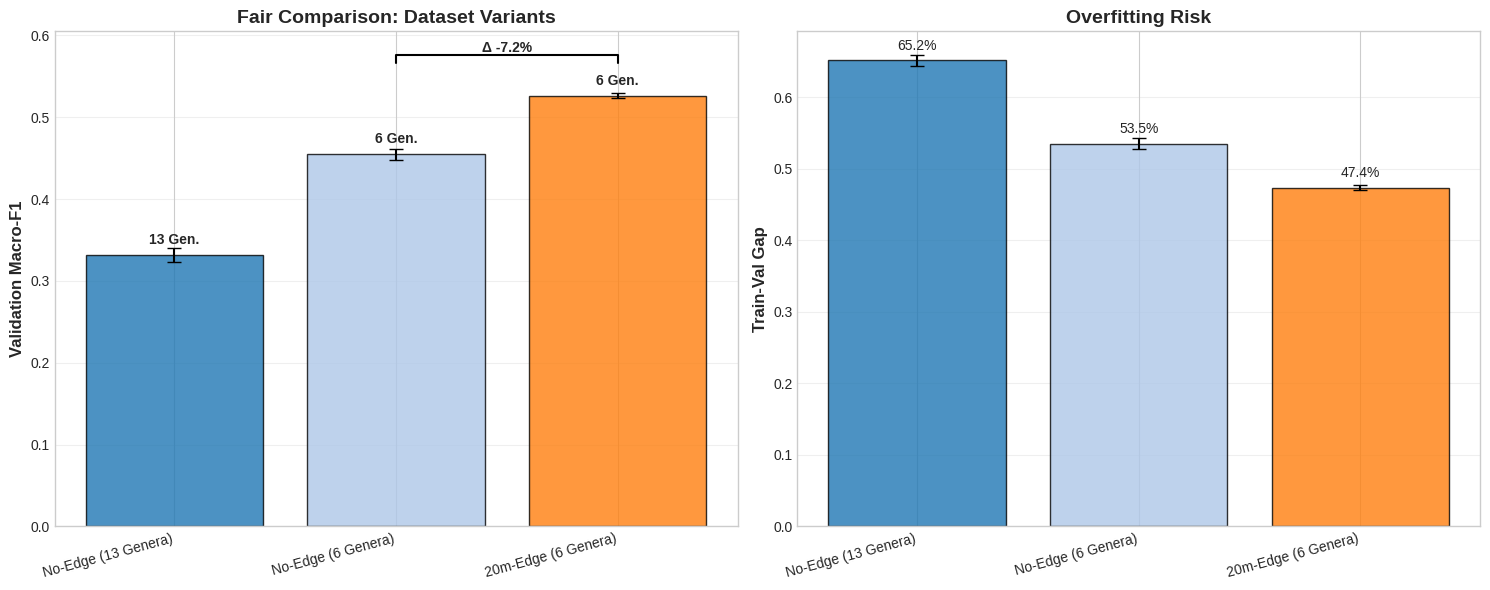

In [76]:
print_subsection("Performance Comparison Visualization")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Prepare data in order A, A_controlled, B
order = ['A', 'A_controlled', 'B']
plot_data = summary_df.set_index('variant').loc[order].reset_index()

variants = plot_data['name'].values
val_f1 = plot_data['mean_val_macro_f1'].values
val_f1_std = plot_data['std_val_macro_f1'].values
genera_counts = plot_data['n_genera'].values
gap_vals = plot_data['mean_train_val_gap'].values
gap_std = plot_data['std_train_val_gap'].values

x_pos = np.arange(len(variants))
# Colors: Blue (Baseline), Light Blue (Control), Orange (Target)
colors = ['#1f77b4', '#aec7e8', '#ff7f0e']

# Plot 1: F1
bars = ax1.bar(x_pos, val_f1, yerr=val_f1_std, capsize=5, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Validation Macro-F1', fontsize=12, fontweight='bold')
ax1.set_title('Fair Comparison: Dataset Variants', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(variants, rotation=15, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Annotate
for i, (bar, count) in enumerate(zip(bars, genera_counts)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{int(count)} Gen.',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Connector for fair comparison
x_ctrl = 1
x_targ = 2
y_max = max(val_f1[x_ctrl], val_f1[x_targ]) + 0.05
ax1.plot([x_ctrl, x_ctrl, x_targ, x_targ], [y_max-0.01, y_max, y_max, y_max-0.01], color='black', lw=1.5)
ax1.text((x_ctrl+x_targ)/2, y_max, f'Δ {delta_f1_fair:+.1%}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Gap
bars2 = ax2.bar(x_pos, gap_vals, yerr=gap_std, capsize=5, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('Train-Val Gap', fontsize=12, fontweight='bold')
ax2.set_title('Overfitting Risk', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(variants, rotation=15, ha='right')
ax2.grid(axis='y', alpha=0.3)

for i, (bar, gap) in enumerate(zip(bars2, gap_vals)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{gap*100:.1f}%',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(RESULTS_PLOTS / "exp_0.2_performance_fair_comparison.png", dpi=300)
plt.show()

### 7.2 Genus-Level Comparison Plot


--------------------------------------------------------------------------------
Genus-Level Comparison Visualization
--------------------------------------------------------------------------------


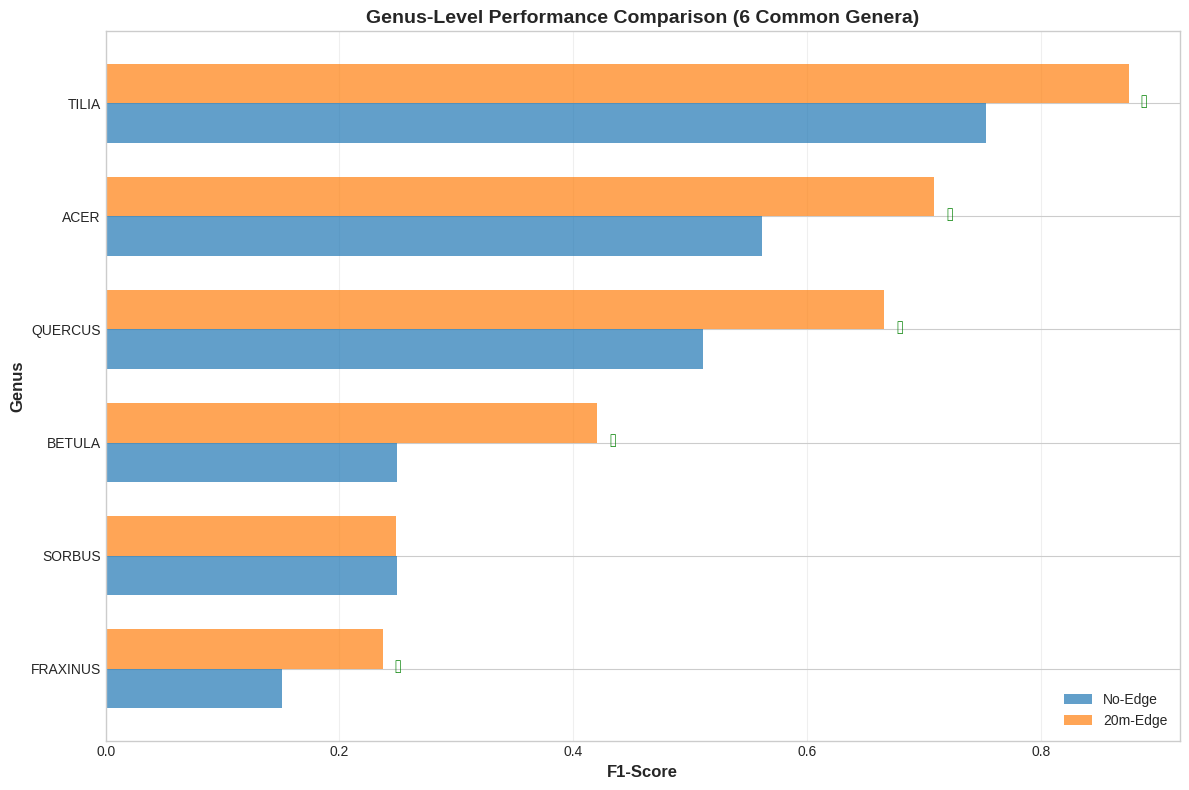

✓ Genus comparison plot saved
  ★ = Genus benefits from 20m-Edge filter (Δ F1 > +5%)


In [77]:
print_subsection("Genus-Level Comparison Visualization")

if len(genus_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Prepare data
    genus_df_sorted = genus_df.sort_values('f1_20m_edge', ascending=True)
    genera = genus_df_sorted['genus'].values
    f1_no_edge = genus_df_sorted['f1_no_edge'].values
    f1_edge = genus_df_sorted['f1_20m_edge'].values

    # Create grouped bar chart
    x_pos = np.arange(len(genera))
    width = 0.35

    bars1 = ax.barh(x_pos - width/2, f1_no_edge, width, label='No-Edge', color='#1f77b4', alpha=0.7)
    bars2 = ax.barh(x_pos + width/2, f1_edge, width, label='20m-Edge', color='#ff7f0e', alpha=0.7)

    ax.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_ylabel('Genus', fontsize=12, fontweight='bold')
    ax.set_title(f'Genus-Level Performance Comparison ({len(COMMON_GENERA)} Common Genera)',
                 fontsize=14, fontweight='bold')
    ax.set_yticks(x_pos)
    ax.set_yticklabels(genera)
    ax.legend(loc='lower right')
    ax.grid(axis='x', alpha=0.3)

    # Highlight genera that benefit from edge filter (Δ > +5%)
    for i, (genus, delta) in enumerate(zip(genera, genus_df_sorted['delta_f1'].values)):
        if delta > 0.05:
            ax.text(max(f1_no_edge[i], f1_edge[i]) + 0.01, i, '★',
                   ha='left', va='center', fontsize=14, color='green')

    plt.tight_layout()
    plt.savefig(RESULTS_PLOTS / "exp_0.2_genus_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Genus comparison plot saved")
    print("  ★ = Genus benefits from 20m-Edge filter (Δ F1 > +5%)")
else:
    print("⚠️  No common genera found - skipping genus comparison plot")

---

## 8. EXPORT RESULTS

### 8.1 Save Decision Document

In [78]:
print_subsection("Exporting Results")

# 1. Decision MD
decision_md = f"""# Experiment 0.2: Dataset Selection - FAIR COMPARISON

**Date:** {decision_record['timestamp']}
**Selected:** {decision_record['selected_name']}

## Comparison

| Variant | Genera | Val F1 | Gap |
|---------|--------|--------|-----|
| A (Baseline) | {summary_df[summary_df['variant']=='A']['n_genera'].values[0]} | {summary_df[summary_df['variant']=='A']['mean_val_macro_f1'].values[0]:.4f} | {summary_df[summary_df['variant']=='A']['mean_train_val_gap'].values[0]:.1%} |
| A_ctrl (Fair) | {summary_df[summary_df['variant']=='A_controlled']['n_genera'].values[0]} | {summary_df[summary_df['variant']=='A_controlled']['mean_val_macro_f1'].values[0]:.4f} | {summary_df[summary_df['variant']=='A_controlled']['mean_train_val_gap'].values[0]:.1%} |
| B (Target) | {summary_df[summary_df['variant']=='B']['n_genera'].values[0]} | {summary_df[summary_df['variant']=='B']['mean_val_macro_f1'].values[0]:.4f} | {summary_df[summary_df['variant']=='B']['mean_train_val_gap'].values[0]:.1%} |

**Fair Delta (A_ctrl - B):** {delta_f1_fair:+.4f} ({delta_f1_fair*100:+.1f}%)

## Reasoning

{''.join([f'- {r}\n' for r in rs])}
"""

with open(RESULTS_METADATA / "decision_dataset.md", "w") as f:
    f.write(decision_md)

# 2. CSVs
summary_df.to_csv(RESULTS_DATA / "dataset_comparison.csv", index=False)
if len(genus_df) > 0:
    genus_df.to_csv(RESULTS_DATA / "genus_comparison.csv", index=False)

# 3. YAML for Phase 1
config_partial = {
    "experiment_0.2": {
        "dataset_choice": VARIANTS[decision]['name'],
        "dataset_file_train": VARIANTS[decision]['train_file'],
        "dataset_file_val": VARIANTS[decision]['val_file'],
        "filter_genera": VARIANTS[decision]['filter_genera'],
        "val_f1": float(summary_df[summary_df['variant'] == decision]['mean_val_macro_f1'].values[0])
    }
}

with open(RESULTS_METADATA / "CONFIG_PARTIAL_0.2.yaml", "w") as f:
    yaml.dump(config_partial, f, default_flow_style=False)

print("✓ All results exported")


--------------------------------------------------------------------------------
Exporting Results
--------------------------------------------------------------------------------
✓ All results exported


---

## 9. SUMMARY & INSIGHTS

### 9.1 Key Findings

In [80]:
print("\n" + "="*80)
print("EXPERIMENT 0.2 COMPLETE")
print("="*80)

print(f"\nSummary Statistics:")
print(f"   Trees processed (per variant): {DATASET_CONFIG['sample_size_per_dataset']:,}")
print(f"   Variants tested: 3 (No-Edge Baseline, No-Edge Control, 20m-Edge)")
print(f"   CV folds: {CV_CONFIG['n_splits']}")
print(f"   Total model runs: {3 * CV_CONFIG['n_splits']}")
print(f"   Features used: {len(FEATURE_GROUPS['spectral'])} (spectral only, no CHM)")

print(f"\nDecision:")
print(f"   Selected Dataset: {decision} ({VARIANTS[decision]['name']})")

# Get metrics for selected variant
val_f1 = summary_df[summary_df['variant'] == decision]['mean_val_macro_f1'].values[0]
gap = summary_df[summary_df['variant'] == decision]['mean_train_val_gap'].values[0]
n_gen = summary_df[summary_df['variant'] == decision]['n_genera'].values[0]

print(f"   Val Macro-F1: {val_f1:.4f}")
print(f"   Train-Val Gap: {gap:.4f} ({gap*100:.1f}%)")
print(f"   Genera Count: {n_gen}")

print(f"\nPerformance Comparison (Fair):")
print(f"   Baseline (A, 13 Gen):   {decision_record['metrics']['baseline_f1']:.4f} F1")
print(f"   Control (A_ctrl, 6 Gen): {decision_record['metrics']['control_f1']:.4f} F1")
print(f"   Target (B, 6 Gen):       {decision_record['metrics']['edge_f1']:.4f} F1")
print(f"   Δ Fair (Control - Target): {decision_record['metrics']['delta_fair']:+.4f} ({decision_record['metrics']['delta_fair']*100:+.1f}%)")

print(f"\nOverfitting Analysis (Train-Val Gap):")
# Retrieve gaps from summary_df directly
gap_a = summary_df[summary_df['variant'] == 'A']['mean_train_val_gap'].values[0]
gap_ctrl = summary_df[summary_df['variant'] == 'A_controlled']['mean_train_val_gap'].values[0]
gap_b = summary_df[summary_df['variant'] == 'B']['mean_train_val_gap'].values[0]

print(f"   Baseline Gap: {gap_a:.1%}")
print(f"   Control Gap:  {gap_ctrl:.1%}")
print(f"   Target Gap:   {gap_b:.1%}")
print(f"   ⚠️  All variants show significant overfitting (expected - no hyperparameter tuning yet)")

if len(genus_df[genus_df['delta_f1'] > 0.05]) > 0:
    print(f"\nGenera Benefiting from 20m-Edge Filter (Top Gainers):")
    for _, row in genus_df[genus_df['delta_f1'] > 0.05].iterrows():
        print(f"   {row['genus']}: {row['delta_f1']:+.4f} ({row['pct_change']:+.1f}%)")
else:
    print(f"\nNo genera benefit significantly from 20m-Edge filter (Δ F1 > +5%)")

print(f"\nOutput Files Generated:")
print(f"   Metadata:")
print(f"     - decision_dataset.md")
print(f"     - CONFIG_PARTIAL_0.2.yaml")
print(f"   Data:")
print(f"     - dataset_comparison.csv")
print(f"     - genus_comparison.csv")
print(f"   Plots:")
print(f"     - exp_0.2_performance_fair_comparison.png")
# print(f"     - exp_0.2_genus_comparison.png") # Note: Might not be generated if no common genera

print(f"\nOutput Directory: {EXPERIMENT_DIR}")

print(f"\nNext: Experiment 1.1 (Temporal Coverage)")

print("\n" + "="*80)
print("ALL TASKS COMPLETED SUCCESSFULLY")
print("="*80)


EXPERIMENT 0.2 COMPLETE

Summary Statistics:
   Trees processed (per variant): 50,000
   Variants tested: 3 (No-Edge Baseline, No-Edge Control, 20m-Edge)
   CV folds: 3
   Total model runs: 9
   Features used: 144 (spectral only, no CHM)

Decision:
   Selected Dataset: B (20m-Edge (6 Genera))
   Val Macro-F1: 0.5261
   Train-Val Gap: 0.4739 (47.4%)
   Genera Count: 6

Performance Comparison (Fair):
   Baseline (A, 13 Gen):   0.3315 F1
   Control (A_ctrl, 6 Gen): 0.4545 F1
   Target (B, 6 Gen):       0.5261 F1
   Δ Fair (Control - Target): -0.0716 (-7.2%)

Overfitting Analysis (Train-Val Gap):
   Baseline Gap: 65.2%
   Control Gap:  53.5%
   Target Gap:   47.4%
   ⚠️  All variants show significant overfitting (expected - no hyperparameter tuning yet)

Genera Benefiting from 20m-Edge Filter (Top Gainers):
   BETULA: +0.1712 (+68.6%)
   QUERCUS: +0.1553 (+30.4%)
   ACER: +0.1475 (+26.3%)
   TILIA: +0.1221 (+16.2%)
   FRAXINUS: +0.0859 (+56.8%)

Output Files Generated:
   Metadata:
     -

---

**Notebook End**

Exported: 2026-01-20

Author: Silas Pignotti